In [30]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# from scipy.stats import shapiro, boxcox
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler, RobustScaler, PolynomialFeatures
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
import statsmodels.api as sm

# Regressors
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
# Regressors Evaluation
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [31]:
def adj_R2(y_true, y_pred):
    return 1 - (np.sum(np.square(y_true - y_pred)) / np.sum(np.square(y_true - np.mean(y_true))))

### 📌Load Data

In [32]:
dataset = pd.read_csv('weatherHistory.csv')

In [33]:
dataset.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [34]:
# rename columns
dataset.rename(columns={
    'Apparent Temperature (C)': 'ApparentTemp',
    'Temperature (C)': 'Temperature', 
    'Wind Speed (km/h)': 'WindSpeed', 
    'Pressure (millibars)': 'Pressure',
    'Visibility (km)': 'Visibility', 
    'Precip Type': 'PrecipType',
    'Wind Bearing (degrees)': 'WindBearing',
    'Loud Cover': 'LoudCover'
    }
, inplace=True)

In [35]:
dataset.eq(0).mean()

Formatted Date    0.000000
Summary           0.000000
PrecipType        0.000000
Temperature       0.004487
ApparentTemp      0.000886
Humidity          0.000325
WindSpeed         0.013137
WindBearing       0.023440
Visibility        0.001196
LoudCover         0.999985
Pressure          0.013521
Daily Summary     0.000000
dtype: float64

In [36]:
# dataset['DateTime'] = pd.to_datetime(dataset['Formatted Date'],  utc=True).dt.to_period('D')
# convert datetime to timestamp 
# from datetime import datetime
# dtime = datetime(2018, 1, 1, 20)
# print("Datetime: ", dtime)
 
# dtimestamp = dtime.timestamp()
# print("Integer timestamp in seconds: ", int(round(dtimestamp)))
 
# milliseconds = int(round(dtimestamp * 1000))
# print("Integer timestamp in milliseconds: ", milliseconds)


In [37]:
dataset.drop(['Formatted Date', 'Daily Summary', 'LoudCover'], axis=1, inplace=True)

In [38]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67747 entries, 0 to 67746
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Summary       67747 non-null  object 
 1   PrecipType    67603 non-null  object 
 2   Temperature   67746 non-null  float64
 3   ApparentTemp  67746 non-null  float64
 4   Humidity      67746 non-null  float64
 5   WindSpeed     67746 non-null  float64
 6   WindBearing   67746 non-null  float64
 7   Visibility    67746 non-null  float64
 8   Pressure      67746 non-null  float64
dtypes: float64(7), object(2)
memory usage: 4.7+ MB


### 📌Check Null?

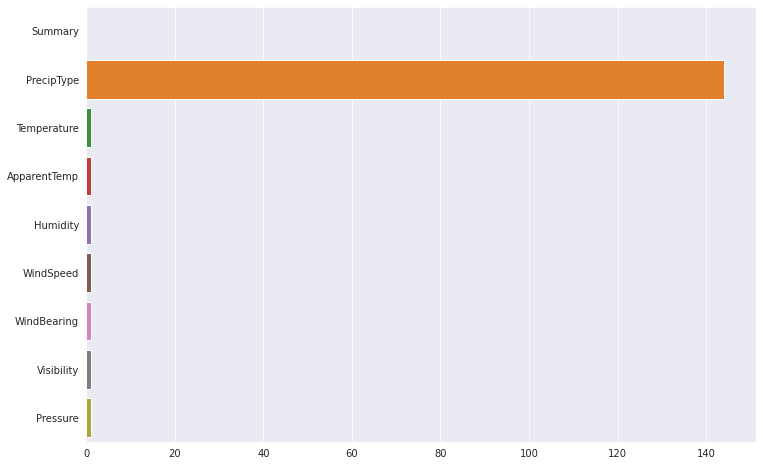

In [39]:
# detected null values by graph
sns.set_style('darkgrid')
plt.figure(figsize=(12,8))
sns.barplot(dataset.isna().sum(), dataset.columns,)
plt.show()

In [40]:
dataset.isna().sum()[dataset.isna().sum() >= 1].sort_values(ascending=False)\
        .reset_index()\
        .rename(columns={'index': 'columns name', 0: 'number of missing values'})

,columns name,number of missing values
0,PrecipType,144
1,Temperature,1
2,ApparentTemp,1
3,Humidity,1
4,WindSpeed,1
5,WindBearing,1
6,Visibility,1
7,Pressure,1


In [41]:
dataset.dropna(inplace=True)

### 📌Check Redundant?

In [42]:
redd_list = []
for col in dataset.columns:
    if dataset[col].value_counts().max()/len(dataset) >= 0.80:
        redd_list.append(col)

dataset[redd_list].value_counts()

PrecipType
rain          58737
snow           8866
dtype: int64

In [43]:
def count_values(df):
    for col in df.columns:
        print(df[col].value_counts())

### 📌 split category and numeric

In [44]:
# binary_col = redd_list
num_col = dataset.select_dtypes(include=np.number).columns
cat_col = dataset.select_dtypes(exclude=np.number).columns 
# len(binary_col),
len(num_col), len(cat_col)

(7, 2)

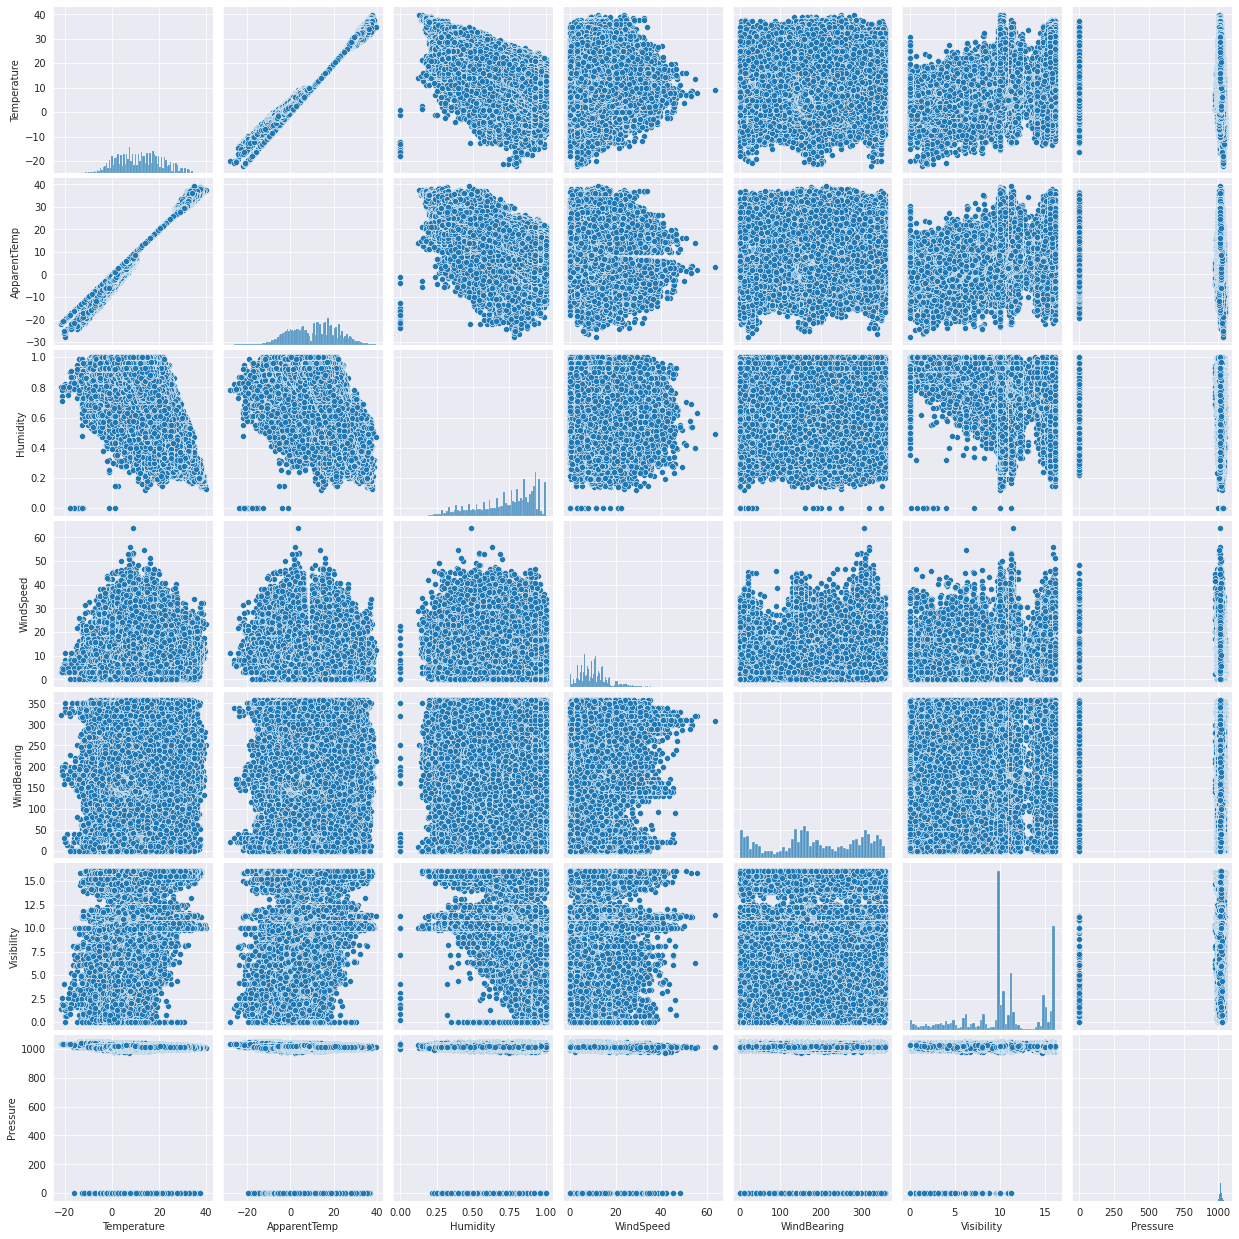

In [ ]:
sns.pairplot(data=dataset)

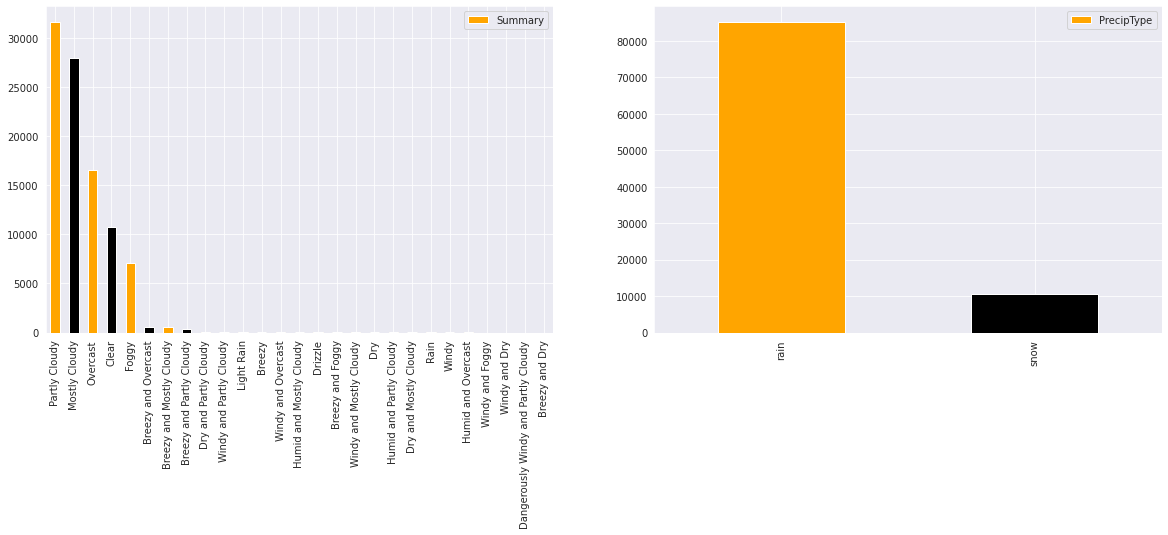

In [ ]:
fig, axs = plt.subplots(1, len(cat_col), figsize=(20, 6))
for col, ax in zip(cat_col, axs):
    dataset[col].value_counts().plot(kind="bar", ax=ax,  stacked=True, legend=True, color=['orange', 'black'])
plt.show()

### 📌 Check Correlation?

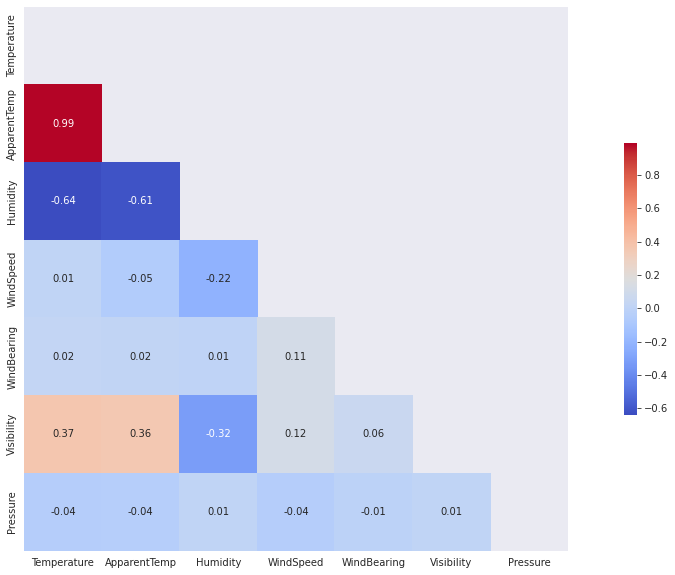

In [48]:
plt.figure(figsize=(20, 10))
corr_mat = dataset[num_col].corr()
mask =  np.triu(np.ones_like(corr_mat, dtype=bool))

sns.heatmap(corr_mat, mask=mask, annot=True, fmt = ".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .5});

In [49]:
def detected_highly_corr(df, target_name, threshold=0.75):
    # exclude categorical data, and target column
    num_cols_without_target = df.drop(columns=[target_name], axis=1).select_dtypes(include=np.number)
    # correlation matrix
    corr_matrix = num_cols_without_target.corr()
    # number of features
    n = len(corr_matrix)
    highly_corr_columns = []

    for row_index in range(n):
        for col_index in range(row_index+1, n):
            if abs(corr_matrix.values[row_index, col_index]) > threshold:
                row_corr_with_target = abs(np.corrcoef(df[target_name], df[num_cols_without_target.columns[row_index]])[0, 1])
                col_corr_with_target = abs(np.corrcoef(df[target_name], df[num_cols_without_target.columns[col_index]])[0, 1])
                    
                if row_corr_with_target > col_corr_with_target:
                    print('column has highly corr ', num_cols_without_target.columns[col_index])
                    highly_corr_columns.append(num_cols_without_target.columns[col_index])
                else:
                    print('column has highly corr', num_cols_without_target.columns[row_index])
                    highly_corr_columns.append(num_cols_without_target.columns[row_index])
    return highly_corr_columns

In [50]:
highly_corr_list = detected_highly_corr(dataset, 'Temperature')

In [51]:
# arrange order of columns
dataset = dataset[['Summary', 'PrecipType', 'WindSpeed', 'WindBearing', 'Visibility', 'Pressure', 'Humidity', 'ApparentTemp', 'Temperature']]

In [54]:
def remove_less_significant_features(X, Y):
    sl = 0.05
    regression_ols = None
    columns_dropped = np.array([])
    for itr in range(0, len(X.columns)):
        regression_ols = sm.OLS(Y, X).fit()
        max_col = regression_ols.pvalues.idxmax()
        max_val = regression_ols.pvalues.max()
        if max_val > sl:
            # X.drop(max_col, axis='columns', inplace=True)
            columns_dropped = np.append(columns_dropped, [max_col])
        else:
            break
    regression_ols.summary()
    return columns_dropped

In [55]:
remove_less_significant_features(dataset[num_col[1:]], dataset['Temperature'])

array([], dtype=float64)

In [56]:
droped_lowest_values = dataset.Summary.value_counts()[dataset.Summary.value_counts() <= 20].reset_index()['index'].tolist()

In [57]:
droped_lowest_values

['Humid and Partly Cloudy',
 'Light Rain',
 'Dry and Mostly Cloudy',
 'Drizzle',
 'Windy',
 'Windy and Foggy',
 'Humid and Overcast',
 'Dangerously Windy and Partly Cloudy',
 'Windy and Dry',
 'Breezy and Dry']

In [58]:
dataset.set_index('Summary', inplace=True)

In [59]:
dataset.drop(droped_lowest_values, axis=0, inplace=True)

In [60]:
dataset.reset_index(drop=False, inplace=True)

In [61]:
dataset.Summary.value_counts()

Partly Cloudy               22954
Mostly Cloudy               18329
Overcast                    11143
Clear                        8532
Foggy                        5210
Breezy and Mostly Cloudy      382
Breezy and Overcast           351
Breezy and Partly Cloudy      315
Dry and Partly Cloudy          75
Windy and Partly Cloudy        56
Windy and Overcast             38
Breezy and Foggy               33
Dry                            33
Breezy                         32
Humid and Mostly Cloudy        27
Windy and Mostly Cloudy        27
Name: Summary, dtype: int64

### 📌 split X_train and X_VLD

In [110]:
X_train, X_vld = train_test_split(dataset, test_size=0.30, random_state=52)

In [111]:
# binary_col = redd_list
num_col = dataset.select_dtypes(include=np.number).columns
cat_col = dataset.select_dtypes(exclude=np.number).columns
len(num_col), len(cat_col)

(7, 2)

### 📌Check Outlier?

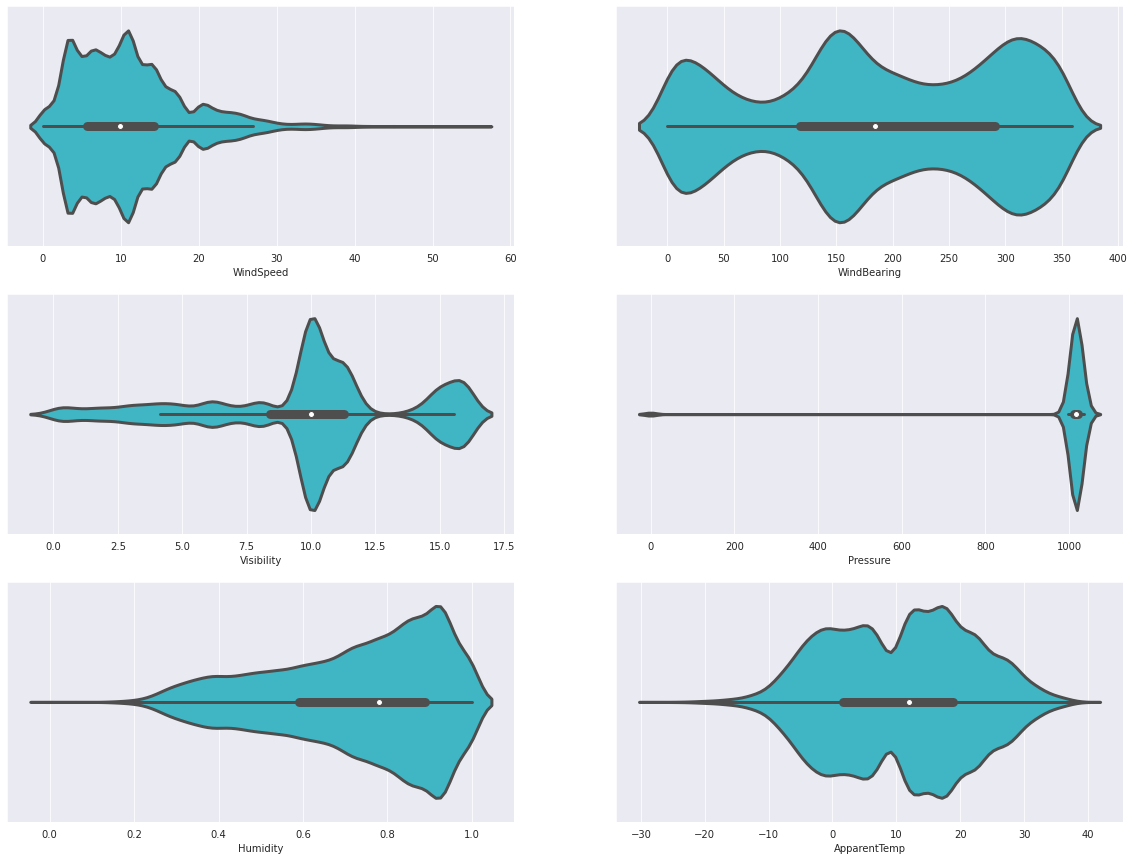

In [80]:
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(20, 15))
for i, ax in zip(range(len(num_col[:-1])), axes.flat):
    sns.violinplot(X_train[num_col[i]], ax=ax, palette='YlGnBu', linewidth=3, saturation=True)
plt.show()

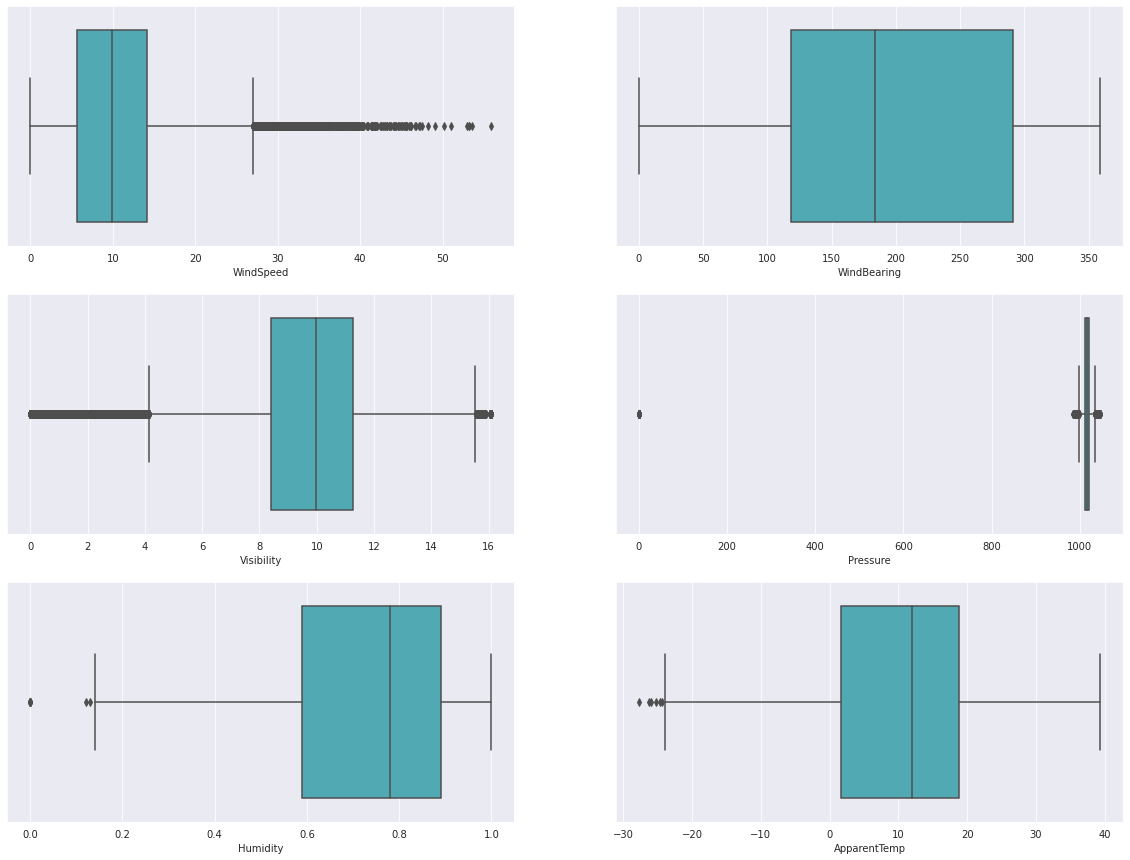

In [97]:
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(20, 15))
for i, ax in zip(range(len(num_col[:-1])), axes.flat):
    sns.boxplot(X_train[num_col[i]], ax=ax, palette='YlGnBu')
plt.show()

In [98]:
# for col in num_col:
#     Q1, Q3 = np.quantile(X_train[col], [0.25, 0.75])
#     IQR = Q3 - Q1
#     lower_Q = Q1 - 1.8 * IQR
#     upper_Q = Q3 + 1.8 * IQR
#     X_train[col] = X_train[col].clip(lower=lower_Q, upper=upper_Q)

### 📌Distribution

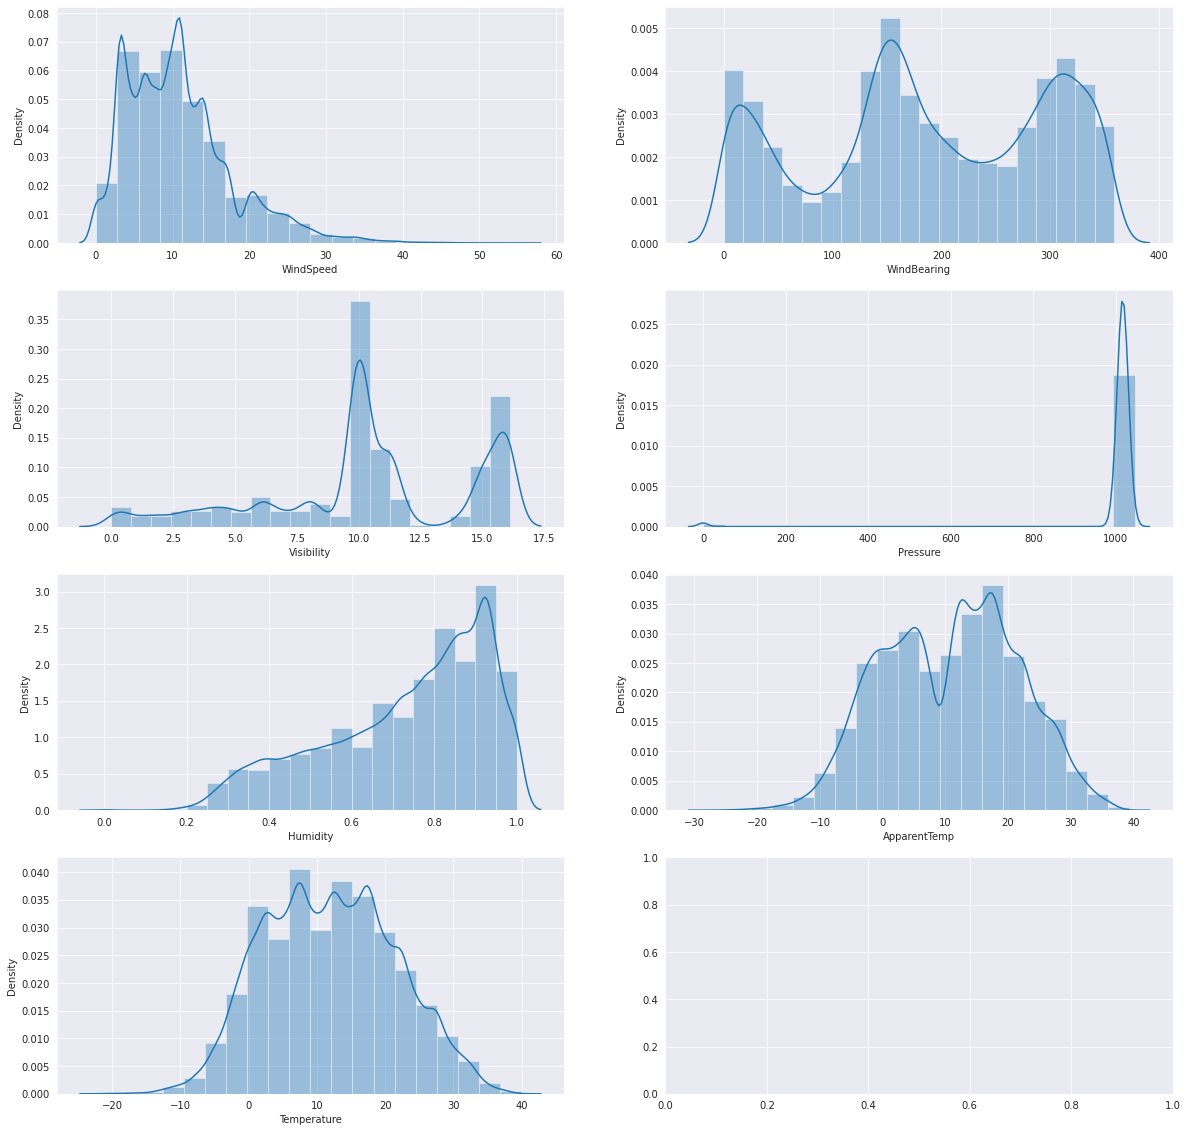

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(20, 20))

for i, ax in zip(range(len(num_col)), axes.flat):
    sns.distplot(dataset[num_col[i]], hist=True, bins=20, ax=ax)
plt.show()

In [112]:
X_train[num_col].describe().T[['mean', '50%', 'std',  'min', 'max']]

,mean,50%,std,min,max
WindSpeed,10.856306,9.917600,7.009127,0.000000,55.931400
WindBearing,189.972946,184.000000,107.762358,0.000000,359.000000
Visibility,9.987536,9.982000,3.870448,0.000000,16.100000
Pressure,1002.882705,1016.410000,118.493188,0.000000,1046.380000
Humidity,0.729064,0.780000,0.198726,0.000000,1.000000
ApparentTemp,10.682884,11.916667,11.083766,-27.716667,39.344444
Temperature,11.804023,11.916667,9.915225,-21.822222,39.905556


### 📌 Skewness

In [117]:
X_train.skew().abs().sort_values(ascending=False)

Pressure        8.364944
WindSpeed       1.122267
Humidity        0.683123
Visibility      0.516272
WindBearing     0.192392
Temperature     0.083981
ApparentTemp    0.058035
dtype: float64

In [116]:
def skew(df, threshold=2):
    sk = df.skew().abs().sort_values(ascending=False).reset_index().rename({0:'value'}, axis=1)
    skew_list = list(sk[sk.value>=threshold]['index'])

    for col_name in skew_list:
        df[col_name] = np.log(1 + df[col_name])
        # df[col_name] = boxcox(df[col_name])[0]
        print('+ Transformed: ', col_name)
    return df

X_train = skew(X_train)
X_vld = skew(X_vld)

+ Transformed:  Pressure
+ Transformed:  Pressure


### 📌Encoding Category

In [118]:
for i in range(len(cat_col)):
    label = LabelEncoder()
    label.fit(X_train[cat_col[i]])
    X_train[cat_col[i]] = label.transform(X_train[cat_col[i]])
    X_vld[cat_col[i]] = label.transform(X_vld[cat_col[i]])

In [ ]:
# one_hot_enc_model = OneHotEncoder(handle_unknown='ignore', sparse=False)
# nominal_train_data = one_hot_enc_model.fit_transform(X_train[cat_col])
# nominal_test_data = one_hot_enc_model.transform(X_vld[cat_col])
# cols = one_hot_enc_model.get_feature_names_out(cat_col)

# # train
# df_train_data = pd.DataFrame(nominal_train_data, columns=cols, index=X_train.index)
# # concat : data
# nominal_train_df = pd.concat([df_train_data, X_train], axis=1)
# nominal_train_df.drop(cat_col, axis=1, inplace=True)

# # validation
# df_test_data = pd.DataFrame(nominal_test_data, columns=cols, index=X_vld.index)
# # concat: data
# nominal_test_df = pd.concat([df_test_data, X_vld], axis=1)
# nominal_test_df.drop(cat_col, axis=1, inplace=True)

In [119]:
minmax = MinMaxScaler()
XX_train = minmax.fit_transform(X_train.values)
XX_vld = minmax.transform(X_vld.values)

In [120]:
XX_train.shape

(47275, 9)

### 📌Separate target 

In [121]:
y_train = XX_train[:,-1]
y_vld = XX_vld[:, -1]

XX_train = XX_train[:,:-1]
XX_vld = XX_vld[:,:-1]

In [122]:
XX_train.shape, y_train.shape, XX_vld.shape, y_vld.shape

((47275, 8), (47275,), (20262, 8), (20262,))

#### ⚡ Features Selections 

---
### $$ Molding $$
---

<p>
There are 3 main metrics for model evaluation in regression:

1. R Square/Adjusted R Square

2. Mean Square Error(MSE)/Root Mean Square Error(RMSE)

3. Mean Absolute Error(MAE)
</p>

In [123]:
def plot_(y_true, y_pred):
    plt.scatter(y_pred, y_true, label='Predicted vs Actual', marker='v', c='#F03358')
    plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], '-o', lw=2, label='Perfect Prediction', c='black', LineWidth=3, alpha=0.5)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.legend(loc='best')
    plt.title(f'Predicted vs Actual ≈ {round(r2_score(y_true, y_pred), 3)}')
    plt.show()


def model_metrics(test_y, pred_y):
    model_r2 = r2_score(test_y, pred_y)
    mse = mean_squared_error(test_y, pred_y)
    rmse = mean_squared_error(test_y, pred_y, squared=False)
    mae = mean_absolute_error(test_y, pred_y)
    adj_r2 = adj_R2(test_y, pred_y)

    print('◤————————————————————————————————————————————————————————————————————————————————————————◥')
    print('     [ R2: %.4f |  adj_r2: %.4f  | MSE: %.4f  |  RMSE: %.4f    | MAE: %.4f]' % (model_r2, adj_r2, mse, rmse, mae))
    print('◣————————————————————————————————————————————————————————————————————————————————————————◢')

In [124]:
# from sklearn.model_selection import GridSearchCV
st = time.time()
# your code
def calc_time(start=None, start_cpu=None):
    if start != None:
        elapsed_time = time.time() - start
        print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
    
    if start_cpu != None:
        res = time.process_time() - start_cpu
        print('CPU Execution time:', round(res, 2), 'seconds')


#### Linear Regression

◤————————————————————————————————————————————————————————————————————————————————————————◥
     [ R2: 0.9903 |  adj_r2: 0.9903  | MSE: 0.0002  |  RMSE: 0.0158    | MAE: 0.0123]
◣————————————————————————————————————————————————————————————————————————————————————————◢


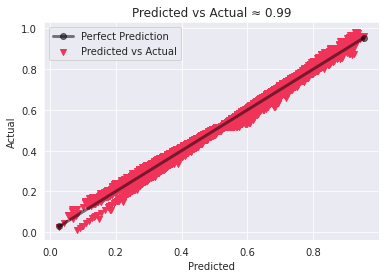

In [125]:
regressors = LinearRegression()
regressors.fit(XX_train, y_train)
y_pred = regressors.predict(XX_vld)

model_metrics(y_vld, y_pred)
plot_(y_vld, y_pred)

#### Multiple Linear Regression

In [127]:
XX_train.shape

(47275, 8)

In [ ]:
select_col = [2, 6, 7]
Xts = XX_train[:, select_col]
Xvs = XX_vld[:, select_col]
print(f"Number of features selected: {Xvs.shape[1]}")

Number of features selected: 3


◤————————————————————————————————————————————————————————————————————————————————————————◥
     [ R2: 0.9901 |  adj_r2: 0.9901  | MSE: 0.0002  |  RMSE: 0.0156    | MAE: 0.0122]
◣————————————————————————————————————————————————————————————————————————————————————————◢


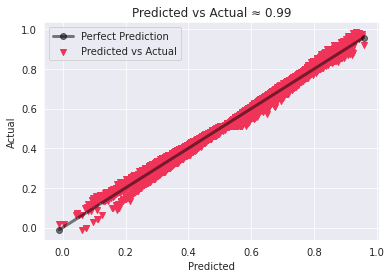

In [ ]:
regressor = LinearRegression()
regressor.fit(Xts, y_train)
y_pred = regressor.predict(Xvs)

model_metrics(y_vld, y_pred)
plot_(y_vld, y_pred)

#### Polynomial Regression

◤————————————————————————————————————————————————————————————————————————————————————————◥
     [ R2: 0.9989 |  adj_r2: 0.9989  | MSE: 0.0000  |  RMSE: 0.0051    | MAE: 0.0036]
◣————————————————————————————————————————————————————————————————————————————————————————◢
Execution time: 00:00:06
CPU Execution time: 6.75 seconds


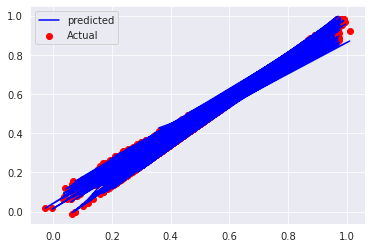

In [ ]:
st = time.time()
st_cpu = time.process_time()
# ---------------------------- #
poly  = PolynomialFeatures(degree=4)
X_train_poly = poly.fit_transform(XX_train)
X_vld_poly = poly.fit_transform(XX_vld)

regressors = LinearRegression()
regressors.fit(X_train_poly, y_train)
y_pred = regressors.predict(X_vld_poly)

model_metrics(y_vld, y_pred)
# plot_(y_vld, y_pred)

# Visualising the Polynomial Regression results
plt.scatter(XX_vld[:,-1], y_vld, color = 'red', label='Actual')
plt.plot(XX_vld[:,-1], y_pred, color = 'blue', label='predicted')
plt.legend();

# ---------------------------- #
calc_time(st, st_cpu)

◤————————————————————————————————————————————————————————————————————————————————————————◥
     [ R2: 0.8437 |  adj_r2: 0.8437  | MSE: 0.0039  |  RMSE: 0.0622    | MAE: 0.0046]
◣————————————————————————————————————————————————————————————————————————————————————————◢
Execution time: 00:01:06
CPU Execution time: 121.13 seconds


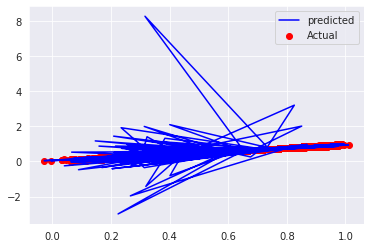

In [ ]:
st = time.time()
st_cpu = time.process_time()
# ---------------------------- #
# when increasing the degree of the polynomial, the model becomes more complex and the fit becomes more unstable.
poly  = PolynomialFeatures(degree=6)
X_train_poly = poly.fit_transform(XX_train)
X_vld_poly = poly.fit_transform(XX_vld)

regressors = LinearRegression()
regressors.fit(X_train_poly, y_train)
y_pred = regressors.predict(X_vld_poly)

model_metrics(y_vld, y_pred)
# plot_(y_vld, y_pred)
# Visualising the Polynomial Regression results
plt.scatter(XX_vld[:,-1], y_vld, color = 'red', label='Actual')
plt.plot(XX_vld[:,-1], y_pred, color = 'blue', label='predicted')
plt.legend();
# ---------------------------- #
calc_time(st, st_cpu)

#### SVR

◤————————————————————————————————————————————————————————————————————————————————————————◥
     [ R2: 0.9891 |  adj_r2: 0.9891  | MSE: 0.0003  |  RMSE: 0.0164    | MAE: 0.0134]
◣————————————————————————————————————————————————————————————————————————————————————————◢


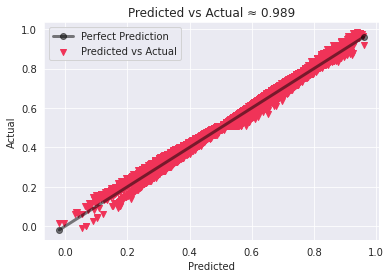

Execution time: 00:01:40
CPU Execution time: 100.64 seconds


In [ ]:
# best result after a set of experiments with changing the parameter
st = time.time()
st_cpu = time.process_time()
# ---------------------------- #
svr = SVR(kernel='linear', C=12, epsilon=0.03)
svr.fit(XX_train, y_train)
y_pred = svr.predict(XX_vld)

model_metrics(y_vld, y_pred)
plot_(y_vld, y_pred)
# ---------------------------- #
calc_time(st, st_cpu)

◤————————————————————————————————————————————————————————————————————————————————————————◥
     [ R2: 0.9915 |  adj_r2: 0.9915  | MSE: 0.0002  |  RMSE: 0.0145    | MAE: 0.0117]
◣————————————————————————————————————————————————————————————————————————————————————————◢


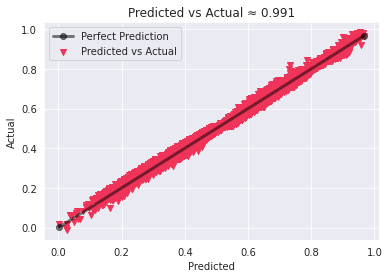

Execution time: 00:00:03
CPU Execution time: 2.98 seconds


In [ ]:
# best result after a set of experiments with changing the parameter
st = time.time()
st_cpu = time.process_time()
# ---------------------------- #
svr = SVR(kernel='rbf', C=34, gamma=0.5, epsilon=0.04, tol=1e-5)
svr.fit(XX_train, y_train)
y_pred = svr.predict(XX_vld)

model_metrics(y_vld, y_pred)
plot_(y_vld, y_pred)
# ---------------------------- #
calc_time(st, st_cpu)

In [ ]:
9+9

◤————————————————————————————————————————————————————————————————————————————————————————◥
     [ R2: 0.9924 |  adj_r2: 0.9924  | MSE: 0.0002  |  RMSE: 0.0137    | MAE: 0.0112]
◣————————————————————————————————————————————————————————————————————————————————————————◢


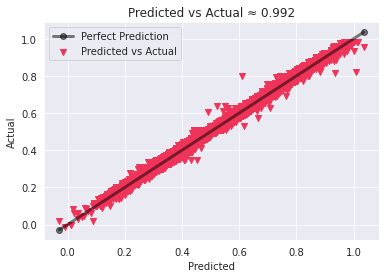

Execution time: 00:04:00
CPU Execution time: 235.22 seconds


In [ ]:
# best result after a set of experiments with changing the parameter
st = time.time()
st_cpu = time.process_time()
# ---------------------------- #
# when increasing the degree of the polynomial, the model becomes more complex and the fit becomes more unstable.
svr = SVR(kernel='poly', degree=7, C=36, gamma=0.6, epsilon=0.03)

svr.fit(XX_train, y_train)
y_pred = svr.predict(XX_vld)

model_metrics(y_vld, y_pred)
plot_(y_vld, y_pred)
# ---------------------------- #
calc_time(st, st_cpu)

### Best Model
<p style='color:blue;'>
all Most Regression Models get higher accuracy:</p>

######  R2_Score ≈ 1    ||    Adj_R2 ≈ 1    ||    MAE ≈  0.2  </p>

In [129]:
result = sm.OLS(y_train, XX_train).fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          7.587e+06
Date:                Sun, 12 Jun 2022   Prob (F-statistic):                        0.00
Time:                        21:00:51   Log-Likelihood:                      1.2888e+05
No. Observations:               47275   AIC:                                 -2.577e+05
Df Residuals:                   47267   BIC:                                 -2.577e+05
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

---
### $$ From ~Skratch ~Implementation $$
---

In [131]:
Xt = XX_train
Xv = XX_vld
yt = y_train.reshape(-1, 1)
yv = y_vld.reshape(-1, 1)

In [132]:
Xt.shape, yt.shape, Xv.shape, yv.shape

((47275, 8), (47275, 1), (20262, 8), (20262, 1))

### Regression Models

In [133]:
def gradient_descent(X, y, alpha=0.001, iterations=100, tol=1e-6, bias=True):    
    m, n = X.shape
    cost_list = []
    theta = np.zeros((n, 1))

    # to add ones(intercept) vector to X matrix
    if bias:
        X = np.concatenate((np.ones((m, 1)), X), axis=1)
        theta = np.zeros((n+1, 1))
        
    for _ in range(iterations):
        hx = np.dot(X, theta)
        error = hx - y
        grad = np.dot(X.T, error) / m
        theta = theta - alpha * grad

        new_cost = np.sum(np.square(error)) / (2 * m)
        cost_list.append(new_cost)
        
        if len(cost_list) >= 2 and abs(cost_list[-1] - cost_list[-2]) < tol:
            break
       
    return theta, hx, cost_list

◤————————————————————————————————————————————————————————————————————————————————————————◥
     [ R2: 0.9903 |  adj_r2: 0.9903  | MSE: 0.0002  |  RMSE: 0.0158    | MAE: 0.0123]
◣————————————————————————————————————————————————————————————————————————————————————————◢


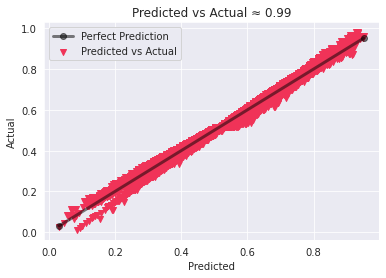

In [140]:
w, ypred, cost_list = gradient_descent(Xt, yt, alpha=0.4, iterations=2500, tol=1e-9, bias=True)

ypred = np.dot(np.concatenate((np.ones((len(Xv), 1)), Xv), axis=1), w)
model_metrics(yv, ypred)
plot_(yv, ypred)

### Polynomial Regression Models

In [141]:
def poly_gradient_descent(X, y, alpha=0.001, iterations=100, tol=1e-6, bias=True, poly=False, degree=3):    
    m, n = X.shape
    cost_list = []
    theta = np.zeros((n, 1))

    # to add ones(intercept) vector to X matrix
    if bias:
        X = np.concatenate((np.ones((m, 1)), X), axis=1)
        theta = np.zeros((n+1, 1))
        m, n = X.shape
    
    # polynomial part
    p=0
    if poly:
        for p in range(degree+1):
          if p != 0:
              x_pow = np.power(X, p)
              X = np.append(X, x_pow, axis = 1)
              theta = np.zeros((X.shape[1], 1))
        
    for _ in range(iterations):
        hx = np.dot(X, theta)
        error = hx - y
        grad = np.dot(X.T, error) / m
        theta = theta - alpha * grad

        new_cost = np.sum(np.square(error)) / (2 * m)
        cost_list.append(new_cost)
        
        if len(cost_list) >= 2 and abs(cost_list[-1] - cost_list[-2]) < tol:
            break
       
    return theta, hx, cost_list

◤————————————————————————————————————————————————————————————————————————————————————————◥
     [ R2: 0.9917 |  adj_r2: 0.9917  | MSE: 0.0002  |  RMSE: 0.0146    | MAE: 0.0102]
◣————————————————————————————————————————————————————————————————————————————————————————◢


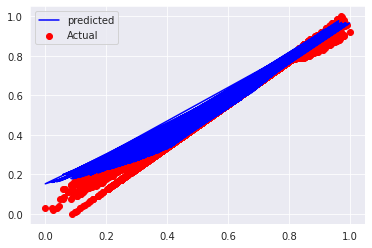

In [144]:
w, ypred, cost_list = poly_gradient_descent(Xt, yt, alpha=0.04, iterations=4000, tol=1e-9, bias=True, poly=True, degree=4)
model_metrics(yt, ypred)

# Visualising the Polynomial Regression results
plt.scatter(Xt[:,-1], yt, color = 'red', label='Actual')
plt.plot(Xt[:,-1], ypred, color = 'blue', label='predicted')
plt.legend();